In [8]:
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
# --- 1. Caricamento del Dataset ---
try:
    G = nx.read_graphml("GoT_cum.graphml")
    print("File caricato con successo.")
except FileNotFoundError:
    print("File non trovato.")

# --- 2. Analisi Preliminare (Capitolo 2 della Tesina) ---

print("\n--- INFO GENERALI SUL GRAFO ---")
print(f"Numero di nodi: {G.number_of_nodes()}")
print(f"Numero di archi: {G.number_of_edges()}")

# Calcolo della densità (quanto è connessa la rete)
density = nx.density(G)
print(f"Densità del grafo: {density:.5f}")

# --- Ispezione dei Dati ---
print("\n --- ESEMPIO DI DATI ---")

# Prende il primo nodo e mostra i suoi attributi
first_node = list(G.nodes(data=True))[0]
print(f"Primo nodo (ID e Attributi): {first_node}")

# Prende il primo arco e mostra il suo peso
first_edge = list(G.edges(data=True))[0]
print(f"Primo Arco (Relazione e Peso): {first_edge}")

File caricato con successo.

--- INFO GENERALI SUL GRAFO ---
Numero di nodi: 338
Numero di archi: 940
Densità del grafo: 0.01650

 --- ESEMPIO DI DATI ---
Primo nodo (ID e Attributi): ('n0', {'label': 'Addam Marbrand'})
Primo Arco (Relazione e Peso): ('n0', 'n1', {'weight': 3.76})


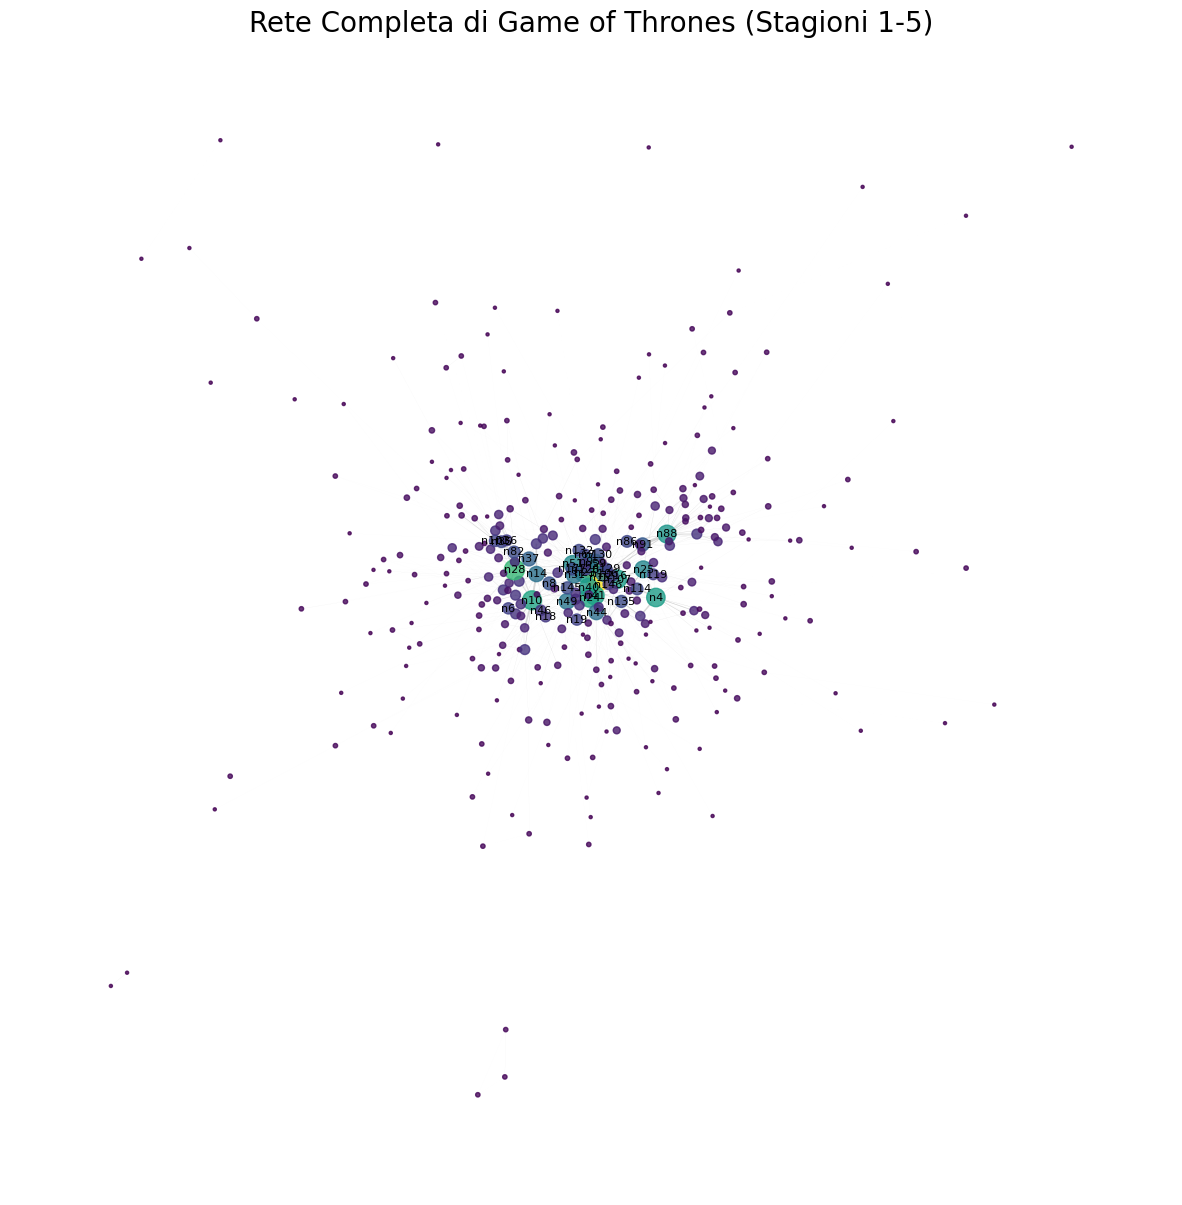

In [10]:
# --- CONFIGURAZIONE VISUALIZZAZIONE ---
plt.figure(figsize=(15, 15))

# 1. Calcoliamo il layout (la posizione dei nodi)
# k=0.15 regola la distanza tra i nodi (più è alto, più sono distanti)
# iterations=20 aiuta a districare meglio la matassa
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

# 2. Calcoliamo la dimensione dei nodi in base al grado (per far risaltare i protagonisti)
# Moltiplichiamo per un fattore per renderli visibili
d = dict(G.degree())
node_sizes = [v * 5 for v in d.values()]

# 3. Disegniamo i nodi
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=list(d.values()), # Colore basato sul grado
                       cmap=plt.cm.viridis,         # Scala di colori
                       alpha=0.8)                   # Leggera trasparenza

# 4. Disegniamo gli archi con spessore basato sul peso
weights = [G[u][v]['weight'] for u, v in G.edges()]
# Normalizziamo lo spessore (per evitare linee giganti che coprono tutto)
# Dividiamo per il massimo peso e moltiplichiamo per un fattore
max_weight = max(weights)
edge_widhts = [(w / max_weight) * 2 for w in weights]

nx.draw_networkx_edges(G, pos,
                      width=edge_widhts,
                      alpha=0.3,
                      edge_color='gray')

# 5. Disegniamo le ETICHETTE (Solo per i personaggi principali)
# Mostriamo i nomi solo di chi ha un grado alto (> 10 connessioni) per non creare caos
# Se vuoi vedere TUTTI i nomi, rimuovi l'if
labels = {node: node for node, degree in d.items() if degree > 10}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black')

plt.title("Rete Completa di Game of Thrones (Stagioni 1-5)", fontsize=20)
plt.axis('off') # Rimuove gli assi cartesiani
plt.show()

In [11]:
# Questo passaggio corregge i nomi: da 'n0' -> 'Jon Snow'
mapping = nx.get_node_attributes(G, 'label')
G = nx.relabel_nodes(G, mapping)

print(f"Grafo caricato: {G.number_of_nodes()} nodi (TUTTI INCLUSI).")

Grafo caricato: 338 nodi (TUTTI INCLUSI).


In [12]:
import community as community_louvain  # Se hai python-louvain installato, altrimenti usa il fallback sotto
from networkx.algorithms.community import greedy_modularity_communities

andrebbe runnato uno solo di quelli sopra

L'algoritmo di Louvain ha trovato 11 comunità (Casate/Alleanze).


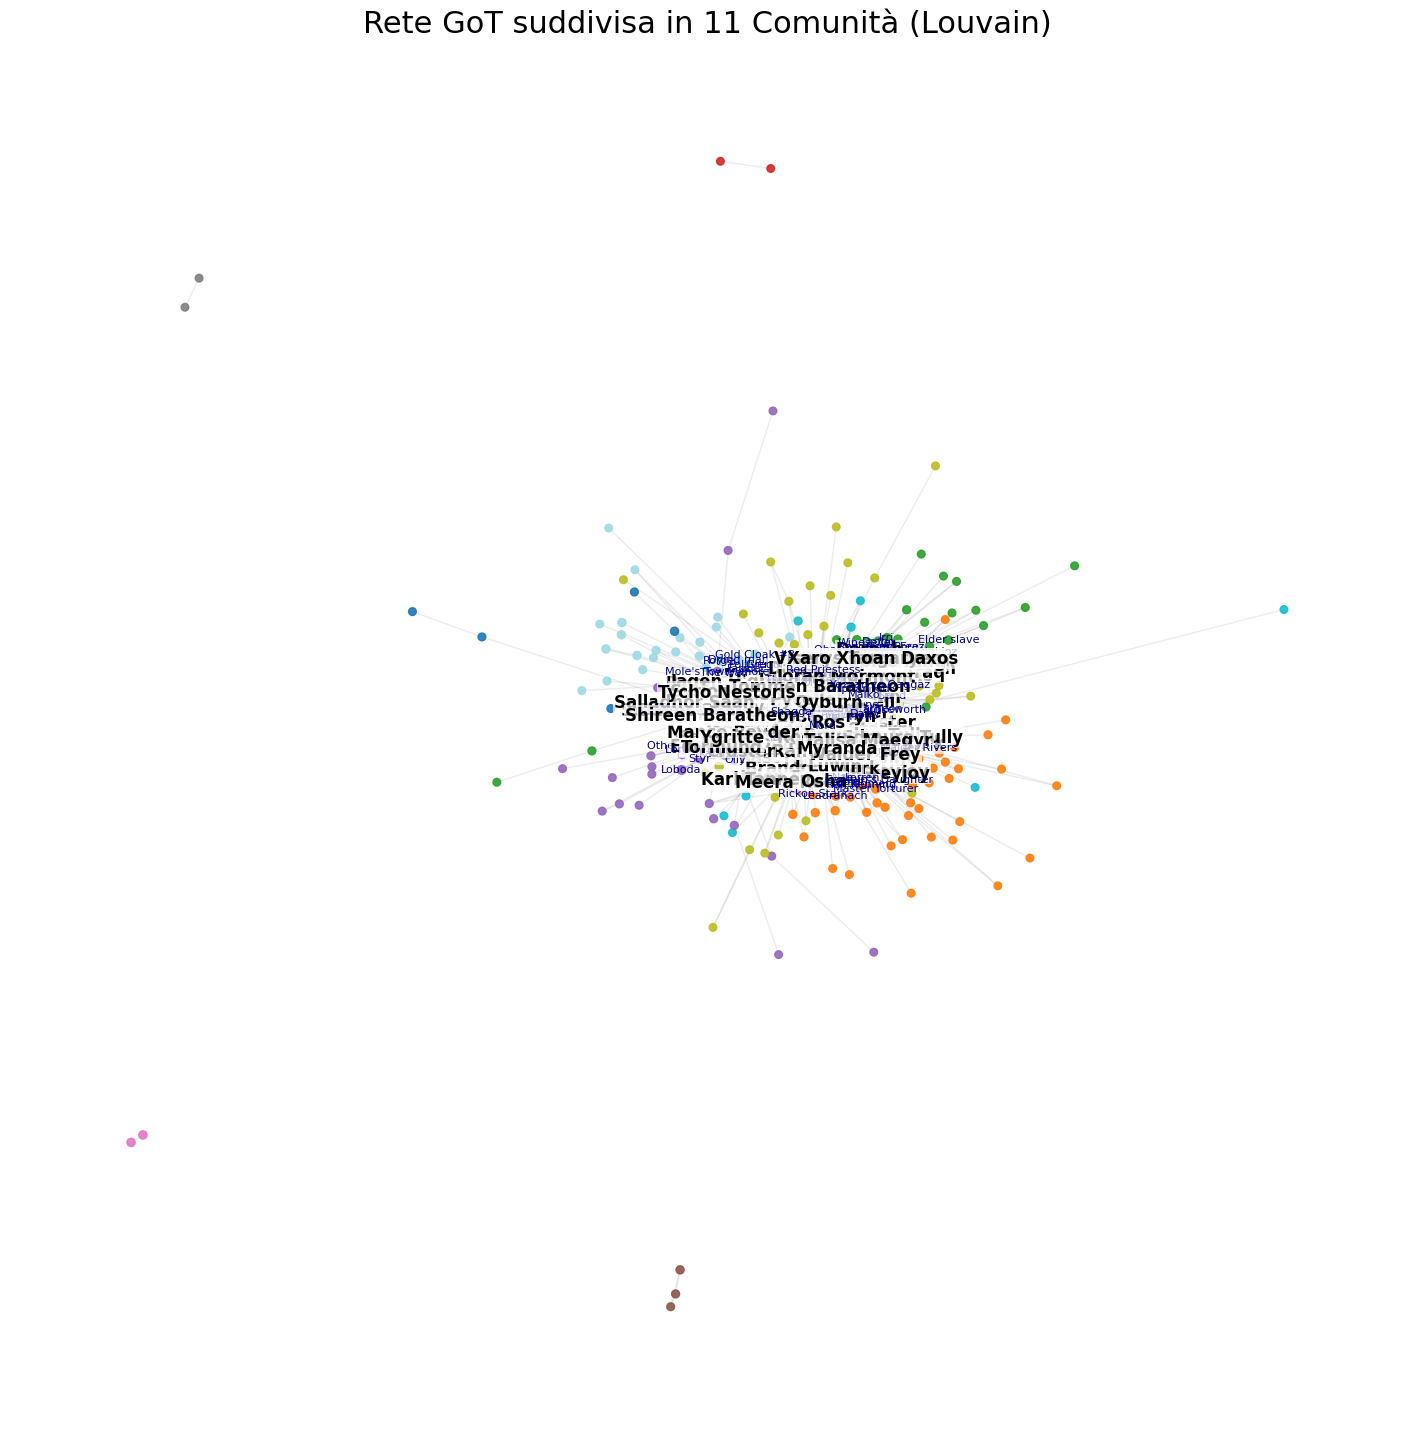

In [15]:
# --- Calcolo delle Comunità (ALGORITMO DI LOUVAIN) ---
# weight='weight' è fondamentale: raggruppa chi si PARLA tanto, non solo chi è collegato.
partition = community_louvain.best_partition(G, weight='weight')

# partition è un dizionario {nodo: comunità}
# Calcoliamo quante comunità ci sono
num_groups = len(set(partition.values()))
print(f"L'algoritmo di Louvain ha trovato {num_groups} comunità (Casate/Alleanze).")

# Prepariamo i colori per ogni comunità
node_colors = [partition[n] for n in G.nodes()]

# --- Layout e Visualizzazione ---
plt.figure(figsize=(18, 18))

# layout a molla
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42, weight='weight')

# Dimensioni in base al grado pesato
degrees = dict(G.degree(weight='weight'))
max_deg = max(degrees.values())
node_sizes = [(degrees[n] / max_deg) * 1000 + 30 for n in G.nodes()]

# --- Diesgno del grafo ---
# Usa la colormap 'tab20' che ha 20 colori distinti, ottima per le community
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       cmap=plt.cm.tab20,
                       alpha=0.9)

nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color='gray')

# --- Etichette per i nodi principali ---
for node, (x, y) in pos.items():
    deg = degrees[node]
    if deg > 200: # Protagonisti (Grandi)  
        plt.text(x, y, node, fontsize=12, fontweight='bold', color='black',
                  ha='center', va='center',
                  bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    elif deg > 50: # Personaggi secondari (Medi)
        plt.text(x, y, node, fontsize=8, color='darkblue', ha='center', va='center')

plt.title(f"Rete GoT suddivisa in {num_groups} Comunità (Louvain)", fontsize=22)
plt.axis('off')
plt.show()

Con resolution=0.85 abbiamo ridotto a 10 macro-comunità.


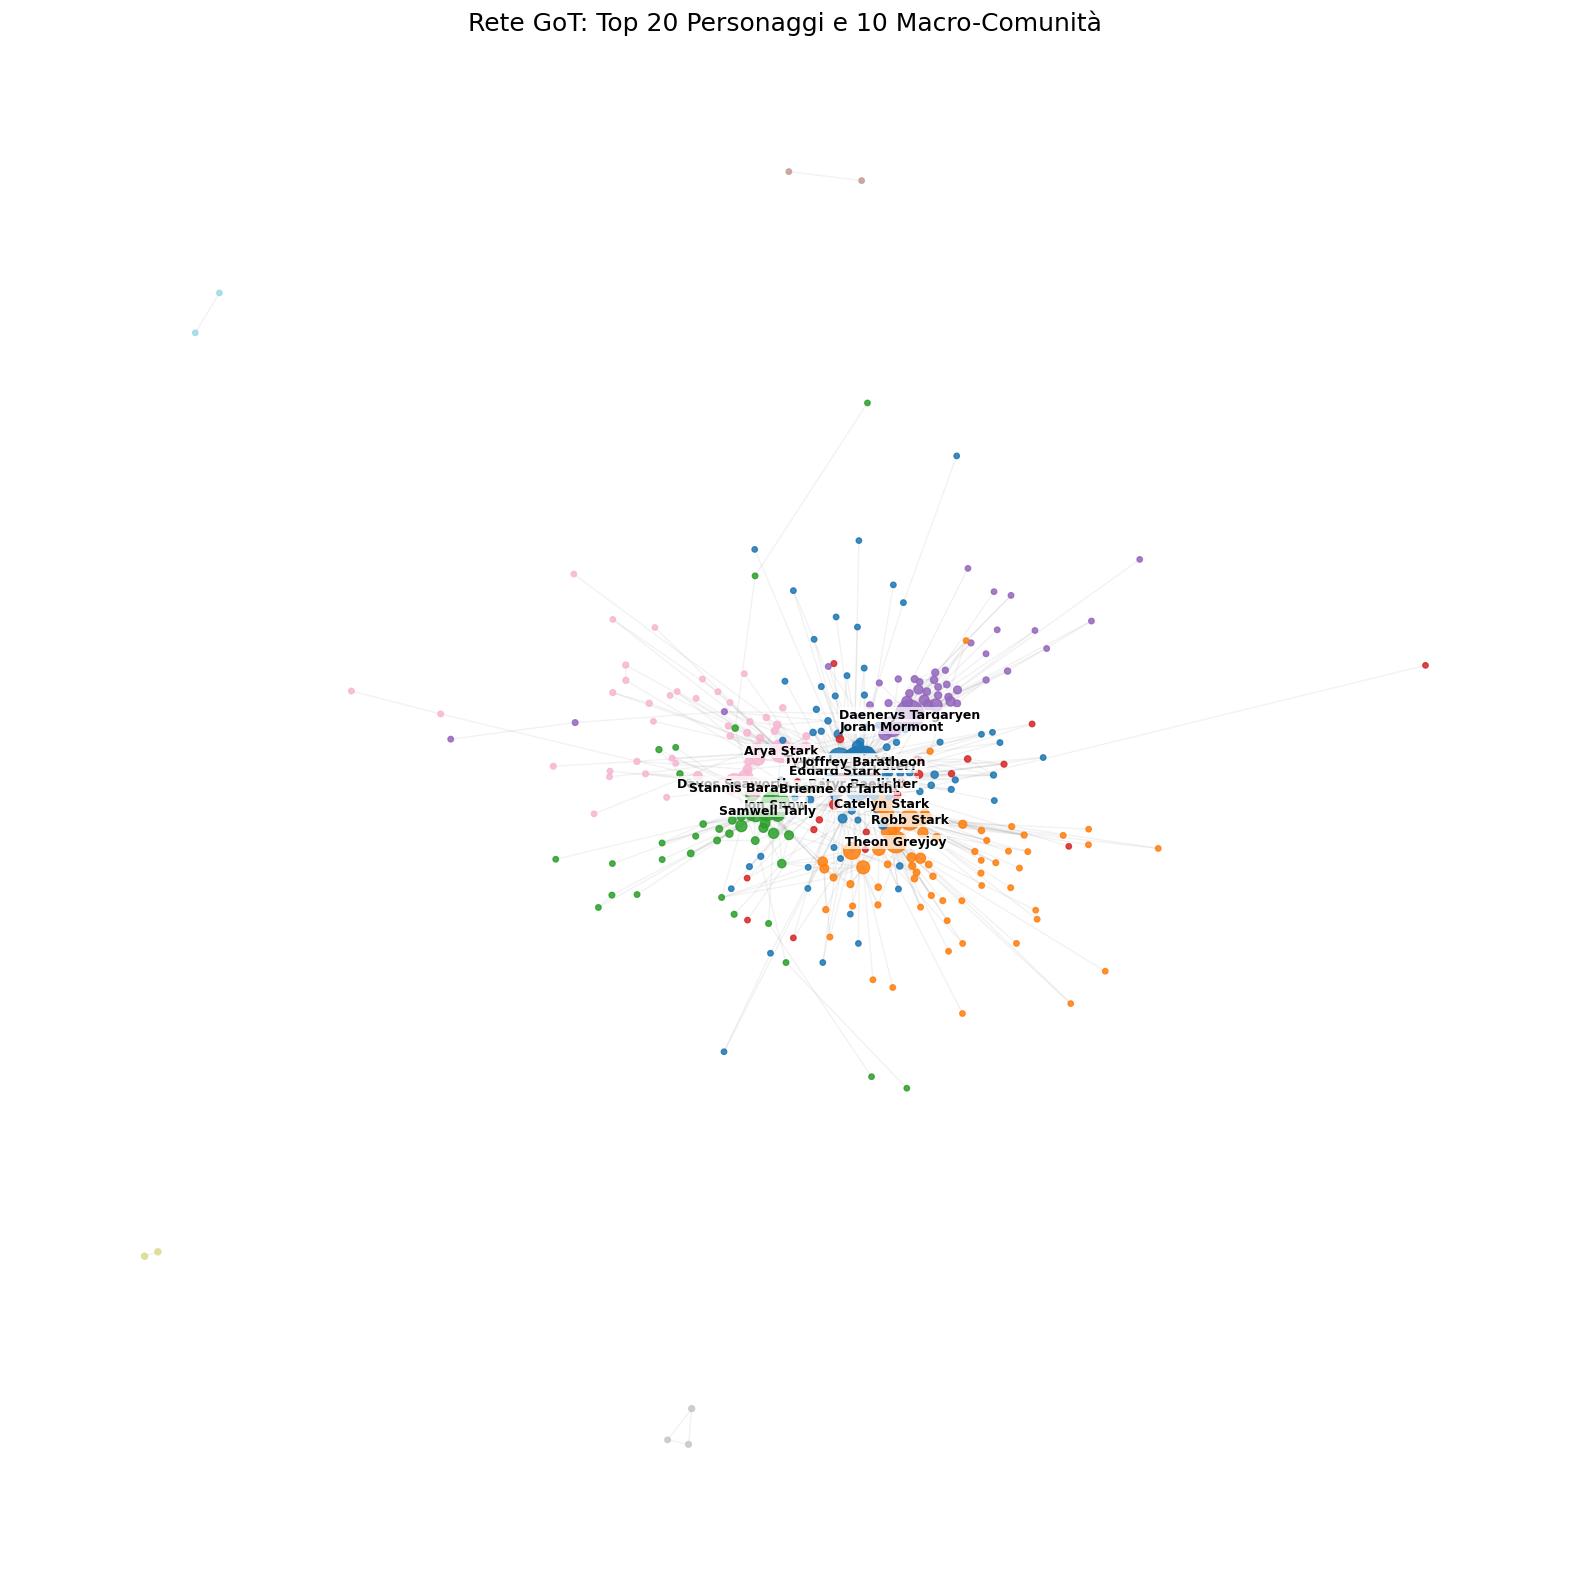

In [ ]:


# --- 1. CARICAMENTO ---
G = nx.read_graphml("got/GoT_cum.graphml")
mapping = nx.get_node_attributes(G, 'label')
G = nx.relabel_nodes(G, mapping)

# --- 2. COMMUNITY DETECTION (CON PARAMETRO RESOLUTION) ---
# resolution < 1.0 -> Tende a creare MENO comunità ma più GRANDI (es. unisce piccoli gruppi)
# resolution > 1.0 -> Tende a creare PIÙ comunità più PICCOLE
partition = community_louvain.best_partition(G, weight='weight', resolution=0.85)

# Calcoliamo quanti gruppi abbiamo trovato ora
num_groups = len(set(partition.values()))
print(f"Con resolution=0.85 abbiamo ridotto a {num_groups} macro-comunità.")

node_colors = [partition[n] for n in G.nodes()]

# --- 3. LAYOUT "ESPANSIVO" ---
plt.figure(figsize=(20, 20)) # Aumentiamo ancora la dimensione del foglio

# Aumentiamo k a 0.20 per "spingere" i nodi più lontano l'uno dall'altro
pos = nx.spring_layout(G, k=0.20, iterations=60, seed=42, weight='weight')

# --- 4. DIMENSIONI ---
degrees = dict(G.degree(weight='weight'))
max_deg = max(degrees.values())
# Riduciamo la dimensione base dei pallini per fare meno "macchia"
node_sizes = [(degrees[n] / max_deg) * 800 + 15 for n in G.nodes()]

# --- 5. DISEGNO DEL GRAFO ---
# Disegno i nodi
nx.draw_networkx_nodes(G, pos, 
                       node_size=node_sizes, 
                       node_color=node_colors, 
                       cmap=plt.cm.tab20, 
                       alpha=0.85)

# Disegno gli archi (ancora più sottili e trasparenti)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

# --- 6. ETICHETTE (SOLO I TOP 20) ---
# Creiamo una lista ordinata dei personaggi più importanti
top_characters = sorted(degrees, key=degrees.get, reverse=True)[:20]

# Disegniamo SOLO quelle etichette
labels_to_draw = {node: node for node in top_characters}

# Font piccolo (9) e sfondo bianco per leggerezza
nx.draw_networkx_labels(G, pos, labels=labels_to_draw, 
                        font_size=9, 
                        font_weight='bold', 
                        font_family='sans-serif',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

plt.title(f"Rete GoT: Top 20 Personaggi e {num_groups} Macro-Comunità", fontsize=18)
plt.axis('off')
plt.show()